In [177]:
from IPython.display import Image, SVG
import Reaction_Library as RL 
from rdkit import Chem
import json
from rdkit.Chem import AllChem,Draw,Descriptors
import copy
import pandas as pd
import re
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Functions

In [382]:
def count_carbons(x):
    smiles = x.Reaction
    
    metabolite = smiles.split('>>')[1]
    
    new_smiles = metabolite.replace('Cl', '')
    numC = new_smiles.count('C') + new_smiles.count('c')
    
    return numC

def same_numC(x):
    reaction = x.Reaction
    
    new_reaction = reaction.replace('Cl', '')
    
    sub = new_reaction.split('>>')[0]
    prod = new_reaction.split('>>')[1]
    
    sub_numC = sub.count('C') + sub.count('c')
    prod_numC = prod.count('C') + prod.count('c')
    
    if sub_numC != prod_numC:
        return False
    
    return True

def same_numN(x):
    reaction = x.Reaction
    
    sub = reaction.split('>>')[0]
    prod = reaction.split('>>')[1]
    
    sub_numN = sub.count('N')
    prod_numN = prod.count('N')
    
    if sub_numN != prod_numN:
        return False
    
    return True

def SmilesToKegg(x):
    rxn = x.Reaction
    
    sub = rxn.split('>>')[0]
    prod = rxn.split('>>')[1]

    if sub in Kegg_smiles:
        for key in Kegg_smiles_dict:
            if Kegg_smiles_dict[key] == sub:
                kegg_sub = key
    else:
        kegg_sub = 'NA'
    
    if prod in Kegg_smiles:
        for key in Kegg_smiles_dict:
            if Kegg_smiles_dict[key] == prod:
                kegg_prod = key
    else:
        kegg_prod = 'NA'
    
    kegg_rxn = kegg_sub + ' = ' + kegg_prod
    
    if kegg_rxn != 'NA = NA':
        return kegg_rxn
    
    return 'None'

def CompareToKEGG(x):
    rxn = x.Kegg_ID
    
    if rxn != 'None':
        sub = rxn.split(' = ')[0]
        prod = rxn.split(' = ')[1]

        for reaction in Kegg_reaction:
            Kegg_sub = reaction.split('<=>')[0]
            Kegg_prod = reaction.split('<=>')[1]

            #print Kegg_sub, Kegg_prod
            if sub in Kegg_sub and prod in Kegg_prod:
                return reaction

    return 'None'

def categorize_rxn(row):
    rxn = row.Reaction
    
    sub = rxn.split('>>')[0]
    prod = rxn.split('>>')[1]
    
    #G1. Apply reaction_type to substrate
    G1_prods = G1_function(sub) #list of G1 products 
    #G2
    G2_prods = G2_function(sub) #list of G2 products
    #G3
    G3_prods = G3_function(sub) #list of G3 products
    #G4
    G4_prods = G4_function(sub) #list of G4 products 
    
    if len(G1_prods) > 0:
        for x in G1_prods:
            if x == prod:
                return 'G1'
    if len(G2_prods) > 0:
        for x in G2_prods:
            if x == prod:
                return 'G2'
    if len(G3_prods) > 0:
        for x in G3_prods:
            if x == prod:
                return 'G3'
    if len(G4_prods) > 0:
        for x in G4_prods:
            if x == prod:
                return 'G4'

In [383]:
def SmilesToKegg2(rxn):
    
    sub = rxn.split('>>')[0]
    prod = rxn.split('>>')[1]

    if sub in Kegg_smiles:
        for key in Kegg_smiles_dict:
            if Kegg_smiles_dict[key] == sub:
                kegg_sub = key
    else:
        kegg_sub = 'NA'
    
    if prod in Kegg_smiles:
        for key in Kegg_smiles_dict:
            if Kegg_smiles_dict[key] == prod:
                kegg_prod = key
    else:
        kegg_prod = 'NA'
    
    kegg_rxn = kegg_sub + ' = ' + kegg_prod
    
    if kegg_rxn != 'NA = NA':
        return kegg_rxn
    
    return 'None'

# Reaction Lists

In [215]:
# 10 Carbon redox reactions
redox_rxns = pd.read_csv('~/Dropbox/Quantum/redox/data_for_Ben/10C_Redox.csv')

In [216]:
# KEGG reactions
kegg_rxns = pd.read_csv('KEGG_ALL.csv', sep = '\t', engine = 'python')

In [217]:
# Kegg canonical smiles
with open('Kegg_Canonical_Final.json', 'r') as fp:
        Kegg_smiles_dict = json.load(fp)

In [283]:
# Kegg smiles list
Kegg_smiles = []
for x in Kegg_smiles_dict:
    Kegg_smiles.append(Kegg_smiles_dict[x])

In [310]:
# KEGG equations
Kegg_reaction = list(kegg_rxns.EQUATION.values)

In [359]:
kegg_rxns.head()

,DEFINITION,EC_CLASS,EQUATION,KEGG_ID,NAME
0,Polyphosphate + n H2O <=> (n+1) Oligophosphate,3.6.1.10,C00404 + n C00001 <=> (n+1) C02174,R00001,polyphosphate polyphosphohydrolase
1,16 ATP + 16 H2O + 8 Reduced ferredoxin <=> 8 e...,1.18.6.1,16 C00002 + 16 C00001 + 8 C00138 <=> 8 C05359 ...,R00002,Reduced ferredoxin:dinitrogen oxidoreductase (...
2,Diphosphate + H2O <=> 2 Orthophosphate,3.6.1.1,C00013 + C00001 <=> 2 C00009,R00004,diphosphate phosphohydrolase;
3,Urea-1-carboxylate + H2O <=> 2 CO2 + 2 Ammonia,3.5.1.54,C01010 + C00001 <=> 2 C00011 + 2 C00014,R00005,urea-1-carboxylate amidohydrolase
4,2-Acetolactate + CO2 <=> 2 Pyruvate,2.2.1.6,C00900 + C00011 <=> 2 C00022,R00006,pyruvate:pyruvate acetaldehydetransferase (dec...


# Compare Metabolites to Kegg Metabolites

In [339]:
# Get rid of G3 reactions by making sure reactant and product have same number of Nitrogens
redox_rxns['Same_NumN'] = redox_rxns.apply(same_numN, 1)

In [340]:
redox_rxns = redox_rxns[redox_rxns.Same_NumN == True]

In [341]:
# Count carbons for substrate
redox_rxns['numC'] = redox_rxns.apply(count_carbons, 1)

In [342]:
# Get 2,3,4 carbon redox reactions
redox_rxns_2C = redox_rxns[redox_rxns.numC == 2]
redox_rxns_3C = redox_rxns[redox_rxns.numC == 3]
redox_rxns_4C = redox_rxns[redox_rxns.numC == 4]

In [360]:
redox_rxns_2C.head()

,Reaction,Kegg_ID,KEGG_Rxn
0,CCO>>CC,None,False
7,CSCO>>CSC,None,False
8,OCCF>>CCF,None,False
10,NCCO>>CCN,C00189 = C00797,False
11,COCO>>COC,None,False


In [343]:
# Delete unneccesary columns

del redox_rxns_2C['Same_NumN']
del redox_rxns_2C['numC']
del redox_rxns_3C['Same_NumN']
del redox_rxns_3C['numC']
del redox_rxns_4C['Same_NumN']
del redox_rxns_4C['numC']

In [361]:
# Turn dataframes into csv files

#redox_rxns_2C.to_csv('2C_redox_rxns.csv', index = False)
#redox_rxns_3C.to_csv('3C_redox_rxns.csv', index = False)
#redox_rxns_4C.to_csv('4C_redox_rxns.csv', index = False)

In [230]:
redox_list = pd.DataFrame(redox_rxns.Reaction.values, columns = ['Reaction'])

In [231]:
# List of 2,3,4 carbon reactions in case they are needed
rxn_list_2C = list(redox_rxns_2C.Reaction.values)
rxn_list_3C = list(redox_rxns_3C.Reaction.values)
rxn_list_4C = list(redox_rxns_4C.Reaction.values)

2 Carbon reactions

In [374]:
# Run functions on the redox reactions to compare to KEGG
# Kegg_ID converts smiles reaction to reaction in kegg ID form
# KEGG_Rxn outputs the corresponding reaction in KEGG

redox_rxns_2C['Kegg_ID'] = redox_rxns_2C.apply(SmilesToKegg, 1)
redox_rxns_2C['KEGG_Rxn'] = redox_rxns_2C.apply(CompareToKEGG, 1)

In [379]:
redox_rxns_2C.head()

,Reaction,Kegg_ID,KEGG_Rxn
0,CCO>>CC,C00469 = NA,None
7,CSCO>>CSC,NA = C00580,None
8,OCCF>>CCF,None,None
10,NCCO>>CCN,C00189 = C00797,None
11,COCO>>COC,NA = C11144,None


In [380]:
redox_rxns_2C[redox_rxns_2C.KEGG_Rxn != 'None']

,Reaction,Kegg_ID,KEGG_Rxn
7579,O=CCS(=O)(=O)O>>O=S(=O)(O)CCO,C00593 = C05123,C00593 + C00005 + C00080 <=> C05123 + C00006


3 Carbon reactions

In [384]:
redox_rxns_3C['Kegg_ID'] = redox_rxns_3C.apply(SmilesToKegg, 1)
redox_rxns_3C['KEGG_Rxn'] = redox_rxns_3C.apply(CompareToKEGG, 1)

In [386]:
redox_rxns_3C.head()

,Reaction,Kegg_ID,KEGG_Rxn
14,CCCO>>CCC,C05979 = NA,None
18,CSCCO>>CCSC,None,None
21,C=CCO>>C=CC,C02001 = C11505,None
24,OCCCS>>CCCS,NA = C08390,None
29,C#CCO>>C#CC,C05986 = NA,None


In [385]:
redox_rxns_3C[redox_rxns_3C.KEGG_Rxn != 'None']

,Reaction,Kegg_ID,KEGG_Rxn
134,CC(C)=O>>CC(C)O,C00207 = C01845,C00207 + C00005 + C00080 <=> C01845 + C00006
289,C#CC(=O)O>>C#CC=O,C00804 = C05985,C01359 + C00804 <=> C05985 + C00113 + C00001
483,CC(=O)C=O>>CC(=O)CO,C00546 = C05235,C00546 + C00005 + C00080 <=> C05235 + C00006
2240,O=C[C@@H](O)CO>>OCC(O)CO,C02426 = C00116,C02426 + C00005 + C00080 <=> C00116 + C00006


4 Carbon reaction

In [387]:
redox_rxns_4C['Kegg_ID'] = redox_rxns_4C.apply(SmilesToKegg, 1)
redox_rxns_4C['KEGG_Rxn'] = redox_rxns_4C.apply(CompareToKEGG, 1)

In [389]:
redox_rxns_4C.head()

,Reaction,Kegg_ID,KEGG_Rxn
28,CCCCO>>CCCC,C06142 = NA,None
51,CC#CCO>>CC#CC,None,None
53,CSCCCO>>CCCSC,None,None
54,OCCCCO>>CCCCO,NA = C06142,None
59,CCC(C)O>>CCCC,None,None


In [392]:
redox_rxns_4C.head()

,Reaction,Kegg_ID,KEGG_Rxn
28,CCCCO>>CCCC,C06142 = NA,None
51,CC#CCO>>CC#CC,None,None
53,CSCCCO>>CCCSC,None,None
54,OCCCCO>>CCCCO,NA = C06142,None
59,CCC(C)O>>CCCC,None,None


In [391]:
redox_rxns_4C[redox_rxns_4C.Kegg_ID != 'None']

,Reaction,Kegg_ID,KEGG_Rxn
28,CCCCO>>CCCC,C06142 = NA,None
54,OCCCCO>>CCCCO,NA = C06142,None
62,CCOCCO>>CCOCC,C14687 = C13240,None
71,CCSCCO>>CCSCC,NA = C02272,None
81,CCCC=O>>CCCCO,C01412 = C06142,C01412 + C00004 + C00080 <=> C06142 + C00003
85,C#CCCO>>C#CCC,C06146 = NA,None
98,O=CCCCO>>CCCC=O,NA = C01412,None
100,CC(O)CCO>>CCCCO,NA = C06142,None
101,CCOCC=O>>CCOCCO,NA = C14687,None
104,C#CCC=O>>C#CCCO,C06145 = C06146,None


## Visualizations

O=CC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CCC(O)C(O)(P(=O)(O)O)P(=O)(O)O


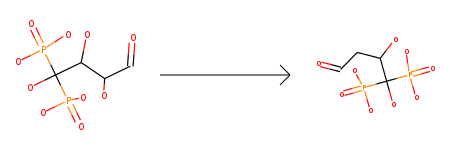

O=C(O)C(O)CC(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)CC(O)(P(=O)(O)O)P(=O)(O)O


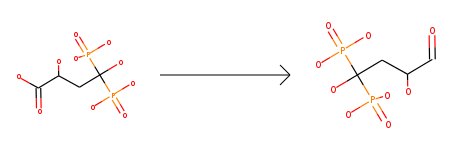

NCC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>NCC(=O)CC(O)(P(=O)(O)O)P(=O)(O)O


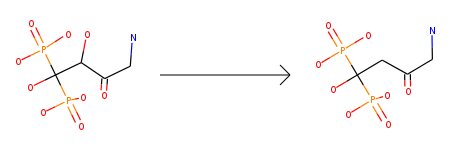

O=CC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)CC(O)(P(=O)(O)O)P(=O)(O)O


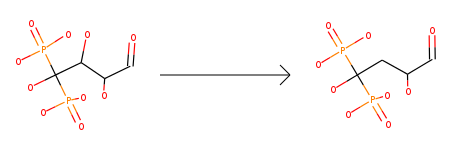

NCC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>NCCC(=O)C(O)(P(=O)(O)O)P(=O)(O)O


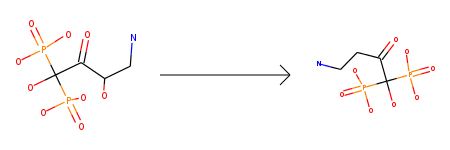

O=C(O)C(O)CC(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)CCC(O)(P(=O)(O)O)P(=O)(O)O


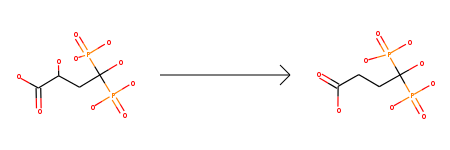

O=C(O)CC(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CCC(O)C(O)(P(=O)(O)O)P(=O)(O)O


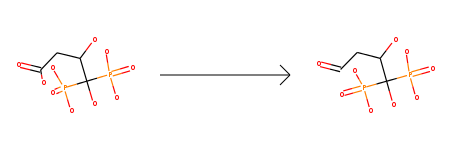

NCC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>NCC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


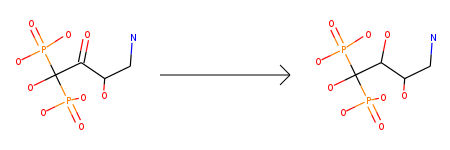

O=CC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(=O)CC(O)(P(=O)(O)O)P(=O)(O)O


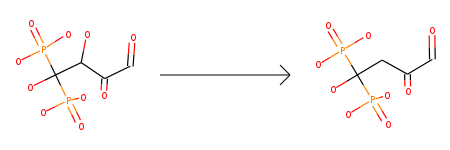

O=CC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CCC(=O)C(O)(P(=O)(O)O)P(=O)(O)O


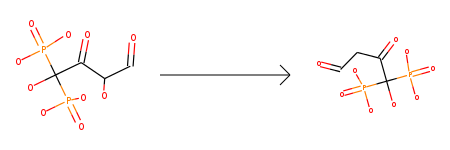

NCC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>NCC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


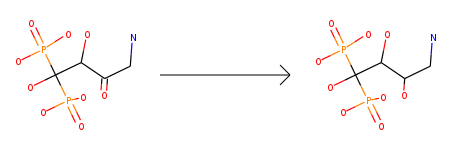

O=C(O)C(=O)CC(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(=O)CC(O)(P(=O)(O)O)P(=O)(O)O


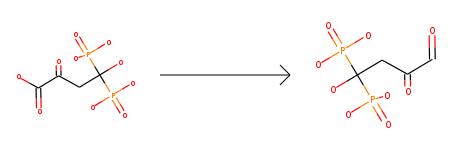

O=C(O)CC(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CCC(=O)C(O)(P(=O)(O)O)P(=O)(O)O


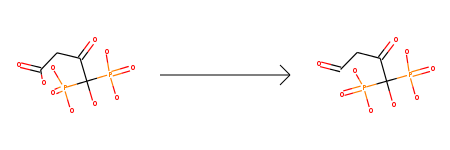

NCC(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>NCC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O


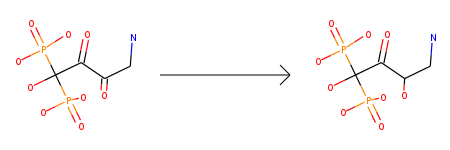

O=CC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


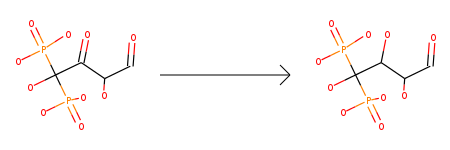

O=C(O)C(=O)CC(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(O)CC(O)(P(=O)(O)O)P(=O)(O)O


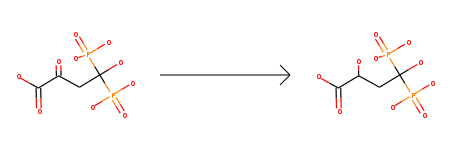

O=CC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


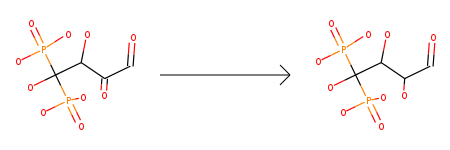

O=C(O)CC(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)CC(O)C(O)(P(=O)(O)O)P(=O)(O)O


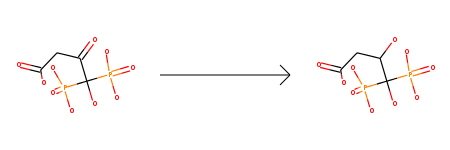

NCC(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>NCC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


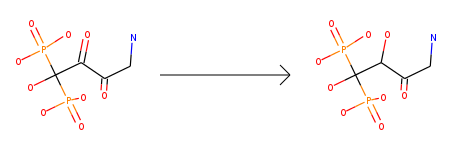

O=CC(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


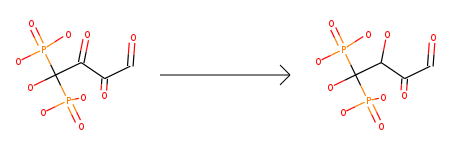

O=CC(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O


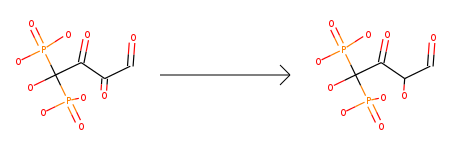

O=C(O)C(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)CC(O)C(O)(P(=O)(O)O)P(=O)(O)O


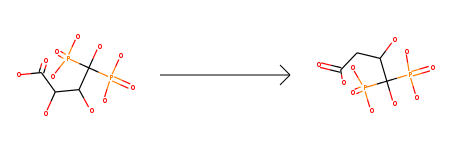

O=C(O)C(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(O)CC(O)(P(=O)(O)O)P(=O)(O)O


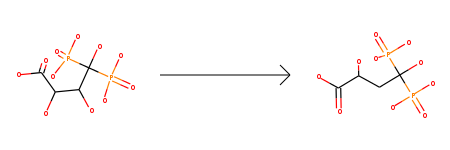

O=C(O)C(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


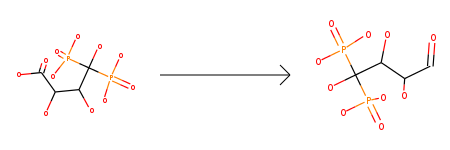

O=C(O)C(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)CC(=O)C(O)(P(=O)(O)O)P(=O)(O)O


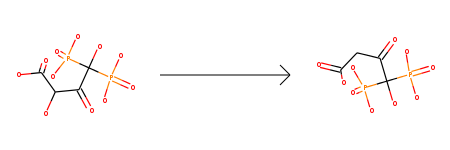

O=C(O)C(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O


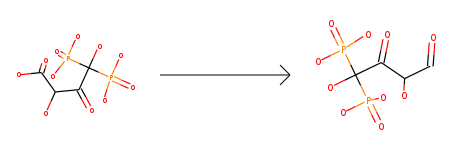

O=C(O)C(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(=O)CC(O)(P(=O)(O)O)P(=O)(O)O


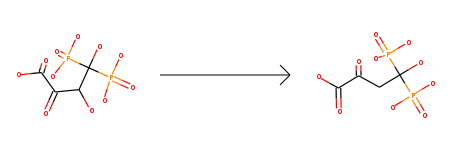

O=C(O)C(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


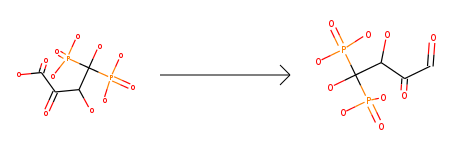

O=C(O)C(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


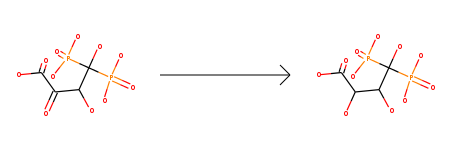

O=C(O)C(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


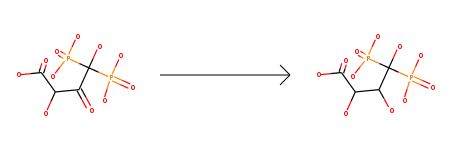

O=C(O)C(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CC(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O


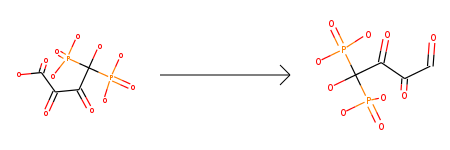

O=C(O)C(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(=O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O


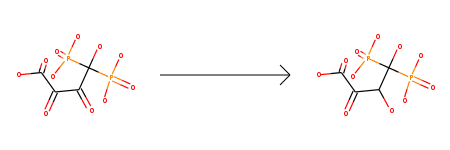

O=C(O)C(=O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=C(O)C(O)C(=O)C(O)(P(=O)(O)O)P(=O)(O)O


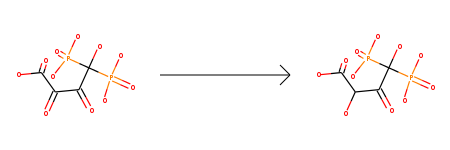

In [200]:
for rxn in rxn_list_4C[2000:2100]:
    print rxn
    display(AllChem.ReactionFromSmarts(str(rxn)))

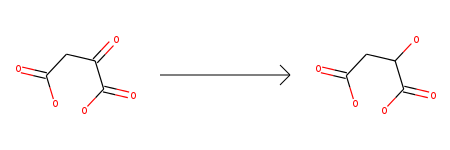

In [348]:
display(AllChem.ReactionFromSmarts('O=C(O)CC(=O)C(=O)O>>O=C(O)C[C@H](O)C(=O)O'))